## Load data

#### A2780 sensitive and resistant combined 

In [1]:
]activate .

  Activating project at `~/Julia`


In [3]:
using Plots
using CSV
using DataFrames
using StatsPlots
using UMAP
using StatsBase
using Statistics
using LinearAlgebra
using SparseArrays
using Loess
using MultivariateStats
using NearestNeighborDescent
using Leiden
using Random
using Distances
using CairoMakie
using CategoricalArrays

In [4]:
import CairoMakie as MK

## Load the raw data from A2780 Seurat Object 

In [5]:
raw_counts = CSV.read("/Users/jingyi/Julia/A2780_rawdata.csv", DataFrame);
rename!(raw_counts, "Column1" => "Genes")

33538×3871 DataFrame
   Row │ Genes        A2780S_CT_S_AAACCTGCAGGGTATG  A2780S_CT_S_AAACCTGGTAGCGT ⋯
       │ String31     Int64                         Int64                      ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ MIR1302-2HG                             0                             ⋯
     2 │ FAM138A                                 0
     3 │ OR4F5                                   0
     4 │ AL627309.1                              0
     5 │ AL627309.3                              0                             ⋯
     6 │ AL627309.2                              0
     7 │ AL627309.4                              0
     8 │ AL732372.1                              0
     9 │ OR4F29                                  0                             ⋯
    10 │ AC114498.1                              0
    11 │ OR4F16                                  0
   ⋮   │      ⋮                    ⋮                             ⋮             ⋱
 33529 │ AC007325.2                              0
 33530 │ BX072566.1                              0                             ⋯
 33531 │ AL354822.1                              0
 33532 │ AC023491.2                              0
 33533 │ AC004556.1                              0
 33534 │ AC233755.2                              0                             ⋯
 33535 │ AC233755.1                              0
 33536 │ AC240274.1                              0
 33537 │ AC213203.1                              0
 33538 │ FAM231C                                 0                             ⋯
                                             3869 columns and 33517 rows omitted

## Calculate percent of mitochondria

In [6]:
mito_genes = filter(row -> startswith(string(row[:Genes]), "MT-"), raw_counts)

13×3871 DataFrame
 Row │ Genes     A2780S_CT_S_AAACCTGCAGGGTATG  A2780S_CT_S_AAACCTGGTAGCGTCC  A ⋯
     │ String31  Int64                         Int64                         I ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ MT-ND1                              41                             6    ⋯
   2 │ MT-ND2                              52                            35
   3 │ MT-CO1                             236                           180
   4 │ MT-CO2                             218                           150
   5 │ MT-ATP8                              0                             0    ⋯
   6 │ MT-ATP6                             49                            27
   7 │ MT-CO3                             180                            58
   8 │ MT-ND3                              32                            20
   9 │ MT-ND4L                              0                             0    ⋯
  10 │ MT-ND4                              84                            64
  11 │ MT-ND5                               3                             4
  12 │ MT-ND6                               1                             0
  13 │ MT-CYB                             103                            63    ⋯
                                                            3868 columns omitted

In [8]:
mito_sum = sum.(eachcol(mito_genes[:,2:end]));
total_sum = sum.(eachcol(raw_counts[:,2:end]));
percent_mito = mito_sum ./ total_sum

3870-element Vector{Float64}:
 0.05112589559877175
 0.0312757625721352
 0.018259281801582473
 0.05154639175257732
 0.039655172413793106
 0.030120481927710843
 0.024857954545454544
 0.0811270673109644
 0.06197527095099985
 0.40584415584415584
 0.109717868338558
 0.06942361259910007
 0.0660886188297945
 ⋮
 0.09861715250275921
 0.017874632713026445
 0.07300021677866898
 0.07457538026873418
 0.5829662261380323
 0.5472355245973008
 0.033271719038817
 0.08008159849356628
 0.621828433346758
 0.09640810929925077
 0.03550295857988166
 0.740431654676259

## Load meta data

In [9]:
metadata = CSV.read("/Users/jingyi/Julia/A2780_metadata.csv", DataFrame);
rename!(metadata, "Column1" => "Cells","orig.ident" => "Identity")

3870×4 DataFrame
  Row │ Cells                         Identity     nCount_RNA  nFeature_RNA 
      │ String31                      String15     Int64       Int64        
──────┼─────────────────────────────────────────────────────────────────────
    1 │ A2780S_CT_S_AAACCTGCAGGGTATG  A2780S_CT_S       19540          3903
    2 │ A2780S_CT_S_AAACCTGGTAGCGTCC  A2780S_CT_S       19408          3499
    3 │ A2780S_CT_S_AAACCTGGTATAGGGC  A2780S_CT_S        1643           859
    4 │ A2780S_CT_S_AAACCTGGTGAAGGCT  A2780S_CT_S         970           661
    5 │ A2780S_CT_S_AAACCTGGTGCCTTGG  A2780S_CT_S         580           404
    6 │ A2780S_CT_S_AAACCTGTCAGTTTGG  A2780S_CT_S        1162           680
    7 │ A2780S_CT_S_AAACCTGTCATGCAAC  A2780S_CT_S        1408           810
    8 │ A2780S_CT_S_AAACGGGCAAGGTGTG  A2780S_CT_S       14693          3462
    9 │ A2780S_CT_S_AAACGGGCACATCTTT  A2780S_CT_S        6551          2232
   10 │ A2780S_CT_S_AAACGGGCAGGCGATA  A2780S_CT_S        2156           864
   11 │ A2780S_CT_S_AAACGGGTCCGAAGAG  A2780S_CT_S         638           415
  ⋮   │              ⋮                     ⋮           ⋮            ⋮
 3861 │ A2780S_CT_R_TTTGCGCAGTAGGTGC  A2780S_CT_R       18452          3845
 3862 │ A2780S_CT_R_TTTGGTTCAAACCCAT  A2780S_CT_R       30439          4971
 3863 │ A2780S_CT_R_TTTGGTTCACAGACAG  A2780S_CT_R         681           251
 3864 │ A2780S_CT_R_TTTGGTTGTAGCGCTC  A2780S_CT_R        6891          1710
 3865 │ A2780S_CT_R_TTTGGTTGTTACGTCA  A2780S_CT_R         541           386
 3866 │ A2780S_CT_R_TTTGTCACAACAACCT  A2780S_CT_R       19118          3891
 3867 │ A2780S_CT_R_TTTGTCACAAGAAAGG  A2780S_CT_R        2483           700
 3868 │ A2780S_CT_R_TTTGTCAGTCTGGTCG  A2780S_CT_R       18152          3899
 3869 │ A2780S_CT_R_TTTGTCATCTGAAAGA  A2780S_CT_R        1014           683
 3870 │ A2780S_CT_R_TTTGTCATCTTGACGA  A2780S_CT_R        3475           656
                                                           3849 rows omitted

## add one column to metadata

In [10]:
A2780_meta = copy(metadata);
A2780_meta[!, :percent_mito] = percent_mito

3870-element Vector{Float64}:
 0.05112589559877175
 0.0312757625721352
 0.018259281801582473
 0.05154639175257732
 0.039655172413793106
 0.030120481927710843
 0.024857954545454544
 0.0811270673109644
 0.06197527095099985
 0.40584415584415584
 0.109717868338558
 0.06942361259910007
 0.0660886188297945
 ⋮
 0.09861715250275921
 0.017874632713026445
 0.07300021677866898
 0.07457538026873418
 0.5829662261380323
 0.5472355245973008
 0.033271719038817
 0.08008159849356628
 0.621828433346758
 0.09640810929925077
 0.03550295857988166
 0.740431654676259

## Plots 

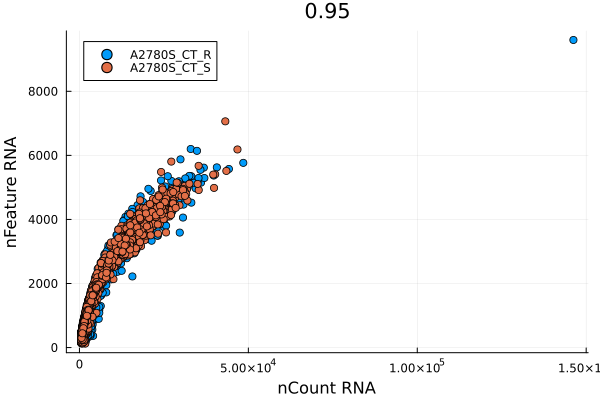

In [13]:
Plots.scatter(A2780_meta.nCount_RNA, 
        A2780S_meta.nFeature_RNA, 
        group=A2780S_meta.Identity,
        xlabel="nCount RNA",
        ylabel="nFeature RNA", 
        title= "0.95")

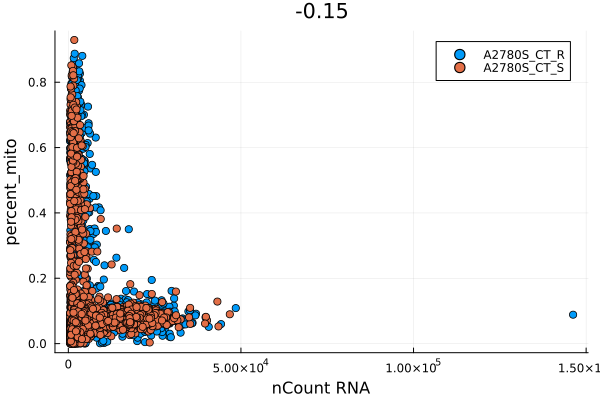

In [14]:
Plots.scatter(A2780_meta.nCount_RNA, 
        A2780S_meta.percent_mito, 
        group=A2780S_meta.Identity,
        xlabel="nCount RNA",
        ylabel="percent_mito", 
        title= "-0.15")

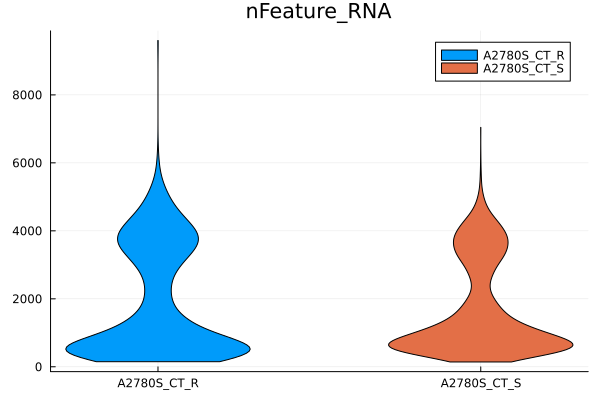

In [15]:
Plots.violin(A2780_meta.Identity,
       A2780S_meta.nFeature_RNA,
       group = A2780S_meta.Identity,
       title = "nFeature_RNA")

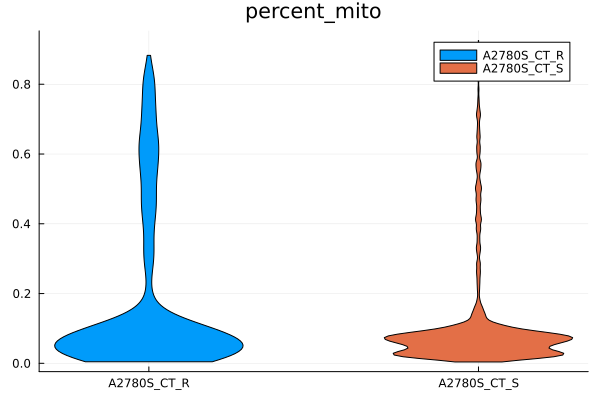

In [16]:
Plots.violin(A2780_meta.Identity,
       A2780S_meta.percent_mito,
       group = A2780S_meta.Identity,
       title = "percent_mito",
       legend = :topright)

In [ ]:
Plots.violin(A2780_meta.Identity,
       A2780S_meta.nCount_RNA,
       group = A2780S_meta.Identity,
       title = "nCount_RNA")

## QC

In [11]:
describe(A2780_meta.nFeature_RNA)

Summary Stats:
Length:         3870
Missing Count:  0
Mean:           1790.596899
Minimum:        123.000000
1st Quartile:   575.000000
Median:         1095.000000
3rd Quartile:   3235.750000
Maximum:        9602.000000
Type:           Int64


In [12]:
@show mean_value_feature = mean(skipmissing(A2780_meta.nFeature_RNA));
@show sd_value_feature = std(skipmissing(A2780_meta.nFeature_RNA));
@show nFeature_Upper = mean_value_feature + 2 * sd_value_feature;
@show nFeature_Lower = 200;

mean_value_feature = mean(skipmissing(A2780_meta.nFeature_RNA)) = 1790.5968992248063
sd_value_feature = std(skipmissing(A2780_meta.nFeature_RNA)) = 1459.8241111706336
nFeature_Upper = mean_value_feature + 2sd_value_feature = 4710.245121566073
nFeature_Lower = 200 = 200


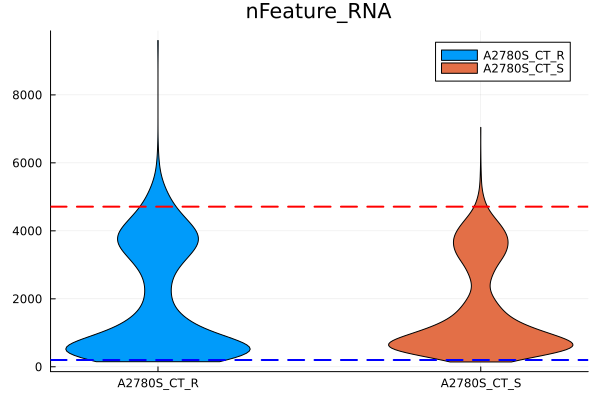

In [17]:
Plots.violin(A2780_meta.Identity,
       A2780_meta.nFeature_RNA,
       group = A2780_meta.Identity,
       title = "nFeature_RNA")
hline!([nFeature_Upper], line=:dash, color=:red, linewidth=2, label = false)
hline!([nFeature_Lower], line=:dash, color=:blue, linewidth=2, label = false)

In [ ]:
#savefig("/Users/jingyi/Julia/A2780S_S+R_ViolinPlot_nFeatures_wCutoffs_1023.pdf")

In [13]:
describe(A2780_meta.percent_mito)

Summary Stats:
Length:         3870
Missing Count:  0
Mean:           0.131966
Minimum:        0.000000
1st Quartile:   0.033962
Median:         0.067723
3rd Quartile:   0.098820
Maximum:        0.929275
Type:           Float64


In [14]:
@show mean_value_perMito = mean(skipmissing(A2780_meta.percent_mito));
@show sd_value_perMito = std(skipmissing(A2780_meta.percent_mito));
@show perMito_Upper = mean_value_perMito + 2 * sd_value_perMito;
@show perMito_Lower = mean_value_perMito - 2 * sd_value_perMito;

mean_value_perMito = mean(skipmissing(A2780_meta.percent_mito)) = 0.13196564783999232
sd_value_perMito = std(skipmissing(A2780_meta.percent_mito)) = 0.18480269138043548
perMito_Upper = mean_value_perMito + 2sd_value_perMito = 0.5015710306008633
perMito_Lower = mean_value_perMito - 2sd_value_perMito = -0.23763973492087864


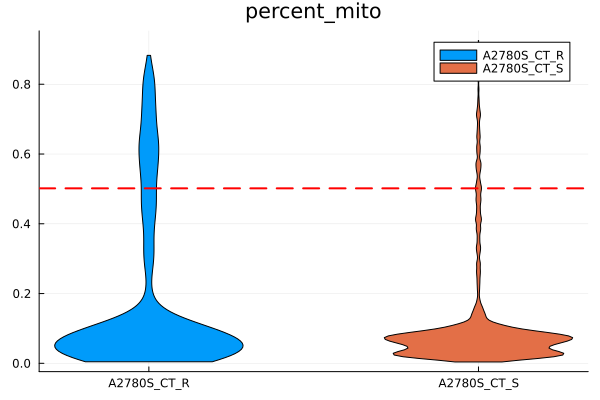

In [22]:
Plots.violin(A2780_meta.Identity,
       A2780_meta.percent_mito,
       group = A2780_meta.Identity,
       title = "percent_mito",
       legend = :topright)
hline!([perMito_Upper], line=:dash, color=:red, linewidth=2, label = false )

## Filter cells 

In [15]:
metadata_filtered = filter(row -> 
                         row[:nFeature_RNA] > nFeature_Lower &&
                         row[:nFeature_RNA] < nFeature_Upper &&
                         row[:percent_mito] < perMito_Upper, A2780_meta)

3449×5 DataFrame
  Row │ Cells                         Identity     nCount_RNA  nFeature_RNA  p ⋯
      │ String31                      String15     Int64       Int64         F ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ A2780S_CT_S_AAACCTGCAGGGTATG  A2780S_CT_S       19540          3903    ⋯
    2 │ A2780S_CT_S_AAACCTGGTAGCGTCC  A2780S_CT_S       19408          3499
    3 │ A2780S_CT_S_AAACCTGGTATAGGGC  A2780S_CT_S        1643           859
    4 │ A2780S_CT_S_AAACCTGGTGAAGGCT  A2780S_CT_S         970           661
    5 │ A2780S_CT_S_AAACCTGGTGCCTTGG  A2780S_CT_S         580           404    ⋯
    6 │ A2780S_CT_S_AAACCTGTCAGTTTGG  A2780S_CT_S        1162           680
    7 │ A2780S_CT_S_AAACCTGTCATGCAAC  A2780S_CT_S        1408           810
    8 │ A2780S_CT_S_AAACGGGCAAGGTGTG  A2780S_CT_S       14693          3462
    9 │ A2780S_CT_S_AAACGGGCACATCTTT  A2780S_CT_S        6551          2232    ⋯
   10 │ A2780S_CT_S_AAACGGGCAGGCGATA  A2780S_CT_S        2156           864
   11 │ A2780S_CT_S_AAACGGGTCCGAAGAG  A2780S_CT_S         638           415
  ⋮   │              ⋮                     ⋮           ⋮            ⋮          ⋱
 3440 │ A2780S_CT_R_TTTATGCTCGTTTATC  A2780S_CT_R       12482          3103
 3441 │ A2780S_CT_R_TTTCCTCAGAGTAATC  A2780S_CT_R       20428          4161    ⋯
 3442 │ A2780S_CT_R_TTTCCTCGTCTCGTTC  A2780S_CT_R         582           427
 3443 │ A2780S_CT_R_TTTCCTCGTGCACCAC  A2780S_CT_R       30806          4463
 3444 │ A2780S_CT_R_TTTCCTCTCGCGGATC  A2780S_CT_R        4084          1926
 3445 │ A2780S_CT_R_TTTGCGCAGTAGGTGC  A2780S_CT_R       18452          3845    ⋯
 3446 │ A2780S_CT_R_TTTGGTTGTTACGTCA  A2780S_CT_R         541           386
 3447 │ A2780S_CT_R_TTTGTCACAACAACCT  A2780S_CT_R       19118          3891
 3448 │ A2780S_CT_R_TTTGTCAGTCTGGTCG  A2780S_CT_R       18152          3899
 3449 │ A2780S_CT_R_TTTGTCATCTGAAAGA  A2780S_CT_R        1014           683    ⋯
                                                  1 column and 3428 rows omitted

In [16]:
filtered_cells = metadata_filtered[!,:Cells]

3449-element Vector{String31}:
 "A2780S_CT_S_AAACCTGCAGGGTATG"
 "A2780S_CT_S_AAACCTGGTAGCGTCC"
 "A2780S_CT_S_AAACCTGGTATAGGGC"
 "A2780S_CT_S_AAACCTGGTGAAGGCT"
 "A2780S_CT_S_AAACCTGGTGCCTTGG"
 "A2780S_CT_S_AAACCTGTCAGTTTGG"
 "A2780S_CT_S_AAACCTGTCATGCAAC"
 "A2780S_CT_S_AAACGGGCAAGGTGTG"
 "A2780S_CT_S_AAACGGGCACATCTTT"
 "A2780S_CT_S_AAACGGGCAGGCGATA"
 "A2780S_CT_S_AAACGGGTCCGAAGAG"
 "A2780S_CT_S_AAACGGGTCCTTTCGG"
 "A2780S_CT_S_AAACGGGTCTTCAACT"
 ⋮
 "A2780S_CT_R_TTTACTGTCCCAAGTA"
 "A2780S_CT_R_TTTACTGTCGGTCCGA"
 "A2780S_CT_R_TTTATGCTCGTTTATC"
 "A2780S_CT_R_TTTCCTCAGAGTAATC"
 "A2780S_CT_R_TTTCCTCGTCTCGTTC"
 "A2780S_CT_R_TTTCCTCGTGCACCAC"
 "A2780S_CT_R_TTTCCTCTCGCGGATC"
 "A2780S_CT_R_TTTGCGCAGTAGGTGC"
 "A2780S_CT_R_TTTGGTTGTTACGTCA"
 "A2780S_CT_R_TTTGTCACAACAACCT"
 "A2780S_CT_R_TTTGTCAGTCTGGTCG"
 "A2780S_CT_R_TTTGTCATCTGAAAGA"

In [17]:
A2780_filtered = select(raw_counts, filtered_cells)
insertcols!(A2780_filtered, 1, :Genes => raw_counts[!,:Genes])

33538×3450 DataFrame
   Row │ Genes        A2780S_CT_S_AAACCTGCAGGGTATG  A2780S_CT_S_AAACCTGGTAGCGT ⋯
       │ String31     Int64                         Int64                      ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ MIR1302-2HG                             0                             ⋯
     2 │ FAM138A                                 0
     3 │ OR4F5                                   0
     4 │ AL627309.1                              0
     5 │ AL627309.3                              0                             ⋯
     6 │ AL627309.2                              0
     7 │ AL627309.4                              0
     8 │ AL732372.1                              0
     9 │ OR4F29                                  0                             ⋯
    10 │ AC114498.1                              0
    11 │ OR4F16                                  0
   ⋮   │      ⋮                    ⋮                             ⋮             ⋱
 33529 │ AC007325.2                              0
 33530 │ BX072566.1                              0                             ⋯
 33531 │ AL354822.1                              0
 33532 │ AC023491.2                              0
 33533 │ AC004556.1                              0
 33534 │ AC233755.2                              0                             ⋯
 33535 │ AC233755.1                              0
 33536 │ AC240274.1                              0
 33537 │ AC213203.1                              0
 33538 │ FAM231C                                 0                             ⋯
                                             3448 columns and 33517 rows omitted

In [18]:
size(A2780_filtered)

(33538, 3450)

### FindVariableFeatures

In [19]:
function Find_variable_genes!(df::DataFrame; span::Float64 = 0.3, mean_min::Float64 = 0.0125, mean_max::Float64 = 3.0 )
    # Extract gene names
    gene_names = df[:, 1]

    # Convert the rest of the DataFrame to a matrix for the count data
    count_mtx = Matrix(df[:, 2:end])

    # Calculate mean of each row, each genes 
    
    mean_val = vec(mean(count_mtx, dims=2)) 
    var_val = vec(var(count_mtx, dims=2))

    # Initialize DataFrame for variance stabilization transformation data
    vst_data = DataFrame(genes = gene_names, mean = mean_val, variance = var_val , variance_expected=zeros(length(mean_val)), variance_standardized=zeros(length(mean_val)))
    
    # Filter out genes with no variance
    # Filter out mean without 0 values 

    vst_data = filter(row -> row.variance != 0 && row.mean != 0, vst_data)
    
    # Fit Loess model
    fit_data = loess(log10.(vst_data.mean), log10.(vst_data.variance), span=span)

    # Predict expected variance
    vst_data.variance_expected = 10 .^ Loess.predict(fit_data, log10.(vst_data.mean))

    # Filter Counts
    
    filtered_genes = vst_data[!,:genes]
    df_filtered = filter(row -> row.Genes ∈ filtered_genes, df)
    filtered_counts = Matrix(df_filtered[:,2:end]) 
    
    # Variance Standardized
    
    mean1 = sparsevec(vst_data.mean)
    var1 = sparsevec(sqrt.(vst_data.variance_expected))
    mat = convert(SparseMatrixCSC{Int64, Int64}, filtered_counts')
    sd_val = collect(var((x .- mean1[i]) ./ var1[i]) for (i, x) in enumerate(eachcol(mat)))
    
    vst_data.variance_standardized = vec(sd_val)
    
    # Filter mean     
       
    vst_data = filter(row -> mean_min <= row.mean <= mean_max, vst_data)
        
    # Rank from high to low 
    
    vst_data = sort(vst_data, :variance_standardized, rev=true)
    
    return vst_data
end


Find_variable_genes! (generic function with 1 method)

In [20]:
features_df = Find_variable_genes!(A2780_filtered)

10425×5 DataFrame
   Row │ genes      mean       variance   variance_expected  variance_standard ⋯
       │ String31   Float64    Float64    Float64            Float64           ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ TMSB4X     0.434619   61.7296            0.742146               83.17 ⋯
     2 │ NTS        0.147289    9.89825           0.186649               53.03
     3 │ ANXA1      0.014497    0.696426          0.0160891              43.28
     4 │ CALCB      0.0661061   3.13832           0.076376               41.09
     5 │ GCG        0.0840823   2.47553           0.0989558              25.01 ⋯
     6 │ HIST1H2BH  0.0258046   0.707861          0.028591               24.75
     7 │ KRT8       0.0171064   0.314382          0.018934               16.60
     8 │ GNG11      0.028414    0.446408          0.031551               14.14
     9 │ CALCA      0.028704    0.409559          0.0318816              12.84 ⋯
    10 │ CTGF       0.0864019   1.21759           0.101939               11.94
    11 │ HIST1H4C   1.39722    46.4396            4.38787                10.58
   ⋮   │     ⋮          ⋮          ⋮              ⋮                    ⋮       ⋱
 10416 │ SSB        2.95187    11.8341           15.8925                  0.74
 10417 │ LAPTM4A    2.27805     7.50126          10.08                    0.74 ⋯
 10418 │ HNRNPM     2.01827     6.03418           8.17456                 0.73
 10419 │ MORF4L1    2.58365     9.24191          12.5606                  0.73
 10420 │ CCT8       2.64048     9.52558          13.0503                  0.72
 10421 │ SPCS2      1.65555     4.25081           5.82792                 0.72 ⋯
 10422 │ RARS       0.660191    0.981364          1.35274                 0.72
 10423 │ CCT4       2.4352      8.20817          11.3233                  0.72
 10424 │ BZW1       1.28762     2.76006           3.83628                 0.71
 10425 │ UQCRC2     1.44999     3.34618           4.66603                 0.71 ⋯
                                                 1 column and 10404 rows omitted

## Normalization

In [21]:
filtered_genes = features_df[!,:genes]
A2780_featured = filter(row -> row.Genes ∈ filtered_genes, A2780_filtered)

10425×3450 DataFrame
   Row │ Genes       A2780S_CT_S_AAACCTGCAGGGTATG  A2780S_CT_S_AAACCTGGTAGCGTC ⋯
       │ String31    Int64                         Int64                       ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ AL669831.5                             0                              ⋯
     2 │ FAM41C                                 0
     3 │ AL645608.3                             0
     4 │ AL645608.1                             0
     5 │ SAMD11                                 0                              ⋯
     6 │ NOC2L                                  1
     7 │ KLHL17                                 0
     8 │ HES4                                   1
     9 │ ISG15                                  0                              ⋯
    10 │ AGRN                                   0
    11 │ C1orf159                               0
   ⋮   │     ⋮                    ⋮                             ⋮              ⋱
 10416 │ DIP2A                                  0
 10417 │ PRMT2                                  1                              ⋯
 10418 │ MT-ATP8                                0
 10419 │ MT-ND4L                                0
 10420 │ MT-ND6                                 1
 10421 │ AC136616.1                             0                              ⋯
 10422 │ AC011043.1                             0
 10423 │ AL592183.1                             0
 10424 │ AC007325.4                             0
 10425 │ AC240274.1                             0                              ⋯
                                             3448 columns and 10404 rows omitted

In [22]:
function Normalize!(df::DataFrame; scale_factor=10000, pseudocount=1)
    #  the first column is gene identifiers, skip it in calculations
    gene_ids = df[!, 1]
    numeric_data = Matrix(df[:, 2:end])

    # Calculate the total expression for each cell
    total_expression = sum(numeric_data, dims=1)

    # Normalize: scale by total expression, multiply by scale factor, add pseudocount, and log-transform
    normalized_data = log.((numeric_data ./ total_expression) .* scale_factor .+ pseudocount)

    # Update the DataFrame with normalized data
    df[:, 2:end] = normalized_data

    return df
end

Normalize! (generic function with 1 method)

In [23]:
A2780_float = convert.(Float64, A2780_featured[:, 2:end])
insertcols!(A2780_float, 1, :Genes => A2780_featured[!,:Genes])

10425×3450 DataFrame
   Row │ Genes       A2780S_CT_S_AAACCTGCAGGGTATG  A2780S_CT_S_AAACCTGGTAGCGTC ⋯
       │ String31    Float64                       Float64                     ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ AL669831.5                           0.0                           0. ⋯
     2 │ FAM41C                               0.0                           0.
     3 │ AL645608.3                           0.0                           0.
     4 │ AL645608.1                           0.0                           0.
     5 │ SAMD11                               0.0                           0. ⋯
     6 │ NOC2L                                1.0                           0.
     7 │ KLHL17                               0.0                           0.
     8 │ HES4                                 1.0                           1.
     9 │ ISG15                                0.0                           0. ⋯
    10 │ AGRN                                 0.0                           0.
    11 │ C1orf159                             0.0                           0.
   ⋮   │     ⋮                    ⋮                             ⋮              ⋱
 10416 │ DIP2A                                0.0                           0.
 10417 │ PRMT2                                1.0                           4. ⋯
 10418 │ MT-ATP8                              0.0                           0.
 10419 │ MT-ND4L                              0.0                           0.
 10420 │ MT-ND6                               1.0                           0.
 10421 │ AC136616.1                           0.0                           0. ⋯
 10422 │ AC011043.1                           0.0                           0.
 10423 │ AL592183.1                           0.0                           0.
 10424 │ AC007325.4                           0.0                           0.
 10425 │ AC240274.1                           0.0                           1. ⋯
                                             3448 columns and 10404 rows omitted

In [24]:
A2780_normalized = Normalize!(A2780_float)

10425×3450 DataFrame
   Row │ Genes       A2780S_CT_S_AAACCTGCAGGGTATG  A2780S_CT_S_AAACCTGGTAGCGTC ⋯
       │ String31    Float64                       Float64                     ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ AL669831.5                       0.0                          0.0     ⋯
     2 │ FAM41C                           0.0                          0.0
     3 │ AL645608.3                       0.0                          0.0
     4 │ AL645608.1                       0.0                          0.0
     5 │ SAMD11                           0.0                          0.0     ⋯
     6 │ NOC2L                            0.78861                      0.0
     7 │ KLHL17                           0.0                          0.0
     8 │ HES4                             0.78861                      0.91133
     9 │ ISG15                            0.0                          0.0     ⋯
    10 │ AGRN                             0.0                          0.0
    11 │ C1orf159                         0.0                          0.0
   ⋮   │     ⋮                    ⋮                             ⋮              ⋱
 10416 │ DIP2A                            0.0                          0.0
 10417 │ PRMT2                            0.78861                      1.93883 ⋯
 10418 │ MT-ATP8                          0.0                          0.0
 10419 │ MT-ND4L                          0.0                          0.0
 10420 │ MT-ND6                           0.78861                      0.0
 10421 │ AC136616.1                       0.0                          0.0     ⋯
 10422 │ AC011043.1                       0.0                          0.0
 10423 │ AL592183.1                       0.0                          0.0
 10424 │ AC007325.4                       0.0                          0.0
 10425 │ AC240274.1                       0.0                          0.91133 ⋯
                                             3448 columns and 10404 rows omitted

## Scale and Center

In [25]:
function Scale!(df::DataFrame; scale_max = 10.0, do_scale::Bool = true, do_center::Bool = true)
    gene_names=df[!,1] 
    count_mtx=Matrix(df[:,2:end])
    rmean = mean(count_mtx, dims=2)
    rsd = sqrt.(var(count_mtx, dims=2))
    count_mtx = hcat(collect(count_mtx[i, :] .- rmean[i] for i in 1:length(rmean))...)
    if do_scale
        count_mtx = hcat([count_mtx[:, i] ./ rsd[i] for i in 1:length(rsd)]...)
    end
    count_mtx = map(x -> x > scale_max ? scale_max : x, count_mtx)
    
    scaled_df = DataFrame(count_mtx', Symbol.(names(df)[2:end]))
    insertcols!(scaled_df, 1, :Genes => gene_names)

    return scaled_df
end

Scale! (generic function with 1 method)

In [26]:
A2780_scaled = Scale!(A2780_normalized)

10425×3450 DataFrame
   Row │ Genes       A2780S_CT_S_AAACCTGCAGGGTATG  A2780S_CT_S_AAACCTGGTAGCGTC ⋯
       │ String31    Float64                       Float64                     ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ AL669831.5                     -0.129681                     -0.12968 ⋯
     2 │ FAM41C                         -0.104735                     -0.10473
     3 │ AL645608.3                     -0.122884                     -0.12288
     4 │ AL645608.1                     -0.116403                     -0.11640
     5 │ SAMD11                         -0.308771                     -0.30877 ⋯
     6 │ NOC2L                           0.113103                     -0.70367
     7 │ KLHL17                         -0.134642                     -0.13464
     8 │ HES4                            0.272702                      0.40916
     9 │ ISG15                          -0.433104                     -0.43310 ⋯
    10 │ AGRN                           -0.227288                     -0.22728
    11 │ C1orf159                       -0.19477                      -0.19477
   ⋮   │     ⋮                    ⋮                             ⋮              ⋱
 10416 │ DIP2A                          -0.19179                      -0.19179
 10417 │ PRMT2                           0.478174                      1.98354 ⋯
 10418 │ MT-ATP8                        -0.123109                     -0.12310
 10419 │ MT-ND4L                        -0.587882                     -0.58788
 10420 │ MT-ND6                          0.190258                     -0.62191
 10421 │ AC136616.1                     -0.117037                     -0.11703 ⋯
 10422 │ AC011043.1                     -0.130305                     -0.13030
 10423 │ AL592183.1                     -0.222284                     -0.22228
 10424 │ AC007325.4                     -0.102954                     -0.10295
 10425 │ AC240274.1                     -0.17073                       3.76348 ⋯
                                             3448 columns and 10404 rows omitted

## PCA

In [27]:
abstract type AbstractCellScope end

# AbstractSingleCell: type for scRNA-seq
abstract type AbstractSingleCell <: AbstractCellScope end
abstract type AbstractCount <: AbstractSingleCell end
abstract type AbstractDimReduction <: AbstractSingleCell end

In [28]:
mutable struct PCAObject <: AbstractDimReduction
    cell_embedding::AbstractMatrix{<:Real}
    pca_model::Union{PCA{Float64}, Nothing}
    percent_var::Union{Vector{Float64}, Nothing}
    key::Union{String, Nothing}
    method::Union{Symbol, Nothing}
    pratio::Union{Real, Nothing}
    maxoutdim::Union{Int64, Nothing}
    PCAObject(cell_embedding, pca_model, percent_var, key, method, pratio, maxoutdim) = new(cell_embedding, pca_model, percent_var, key, method, pratio, maxoutdim)
end


mutable struct UMAPObject <: AbstractDimReduction
    cell_embedding::AbstractMatrix{<:Real}
    key::Union{String, Nothing}
    n_components::Union{Int64, Nothing}
    n_dimensions::Union{Int64, Nothing}
    n_neighbors::Union{Int64, Nothing}
    metric::Union{String, Nothing}
    min_dist::Union{Real, Nothing}
    knn_data::Union{AbstractMatrix{<:Real}, Nothing}
    UMAPObject(cell_embedding, key, n_components, n_dimensions, n_neighbors, metric, min_dist, knn_data) = new(cell_embedding, key, n_components, n_dimensions, n_neighbors, metric, min_dist, knn_data)    
end

mutable struct tSNEObject <: AbstractDimReduction
    cell_embedding::AbstractMatrix{<:Real}
    key::Union{String, Nothing}
    ndim::Union{Int64, Nothing}
    reduce_dims::Union{Int64, Nothing}
    max_iter::Union{Int64, Nothing}
    perplexit::Union{Int64, Nothing}
    tSNEObject(cell_embedding, key, ndim, reduce_dims, max_iter, perplexit) = new(cell_embedding, key, ndim, reduce_dims, max_iter, perplexit)
end


mutable struct ReductionObject <: AbstractDimReduction
    pca::Union{PCAObject, Nothing}
    tsne::Union{tSNEObject, Nothing}
    umap::Union{UMAPObject, Nothing}
    ReductionObject(pca, tsne, umap) = new(pca, tsne, umap)
end

mutable struct ClusteringObject <: AbstractSingleCell
    clustering::DataFrame
    metric::Union{String, Nothing}
    adj_mat::Union{AbstractMatrix{<:Real}, Nothing}
    ledein_res::Union{NamedTuple{(:quality, :partition), Tuple{Float64, Vector{Vector{Int64}}}}, Nothing}
    resolution::Union{Real, Nothing}
    ClusteringObject(clustering, metric, adj_mat, ledein_res, resolution)=new(clustering, metric, adj_mat, ledein_res, resolution)
end

In [30]:
function run_pca(df::DataFrame; method=:svd, pratio=1, maxoutdim=50)
    # Extract gene names (features)
    gene_names = df[!, 1]
    #  the first column is gene_names, the rest are samples with expression data
    # Skip the first column for the data matrix

    data_matrix = Matrix(df[:, 2:end])
    
    # Ensure the matrix is of type Float64 for PCA    
    pca_mat = data_matrix'
    pca_mat = convert(Matrix{Float64}, pca_mat)
    
    # Perform PCA

    M = MultivariateStats.fit(PCA, pca_mat; method=method, pratio=pratio, maxoutdim=maxoutdim)
    proj = MultivariateStats.projection(M)
    percent_var = principalvars(M) ./ tvar(M) * 100
    key = "PC"
    # Create a PCAObject
    pca_obj = PCAObject(proj, M, percent_var, key , method, pratio, maxoutdim)
    reduction_obj = ReductionObject(pca_obj, nothing, nothing)
    
    return pca_obj
end


run_pca (generic function with 1 method)

In [31]:
PCA_obj= run_pca(A2780_scaled)

PCAObject([0.020015587651049715 -0.012150711884561016 … -0.025173411125230902 0.005045641285018573; 0.01596287961502607 -0.001688144001323201 … -0.008504861890933892 -0.003931615390604477; … ; 0.016205099716391027 -0.010388539348288596 … -0.008914752693352205 -0.0012859666813175897; -0.014454710972602642 0.0036047923855152195 … 0.010846272538313197 0.009045247653137606], PCA(indim = 3449, outdim = 50, principalratio = 0.0641073462558202), [1.2389523531503628, 0.45331051132069783, 0.34774375284903397, 0.31229322825785777, 0.24817220565833562, 0.20930645601314335, 0.1508936510126121, 0.13546797964900853, 0.11643356699941304, 0.11092138734026347  …  0.07334895418827243, 0.07326242391269064, 0.07303579687301356, 0.07292325859635725, 0.07269025017455967, 0.07267083325394898, 0.07248594311515774, 0.07234398664029712, 0.07220528890638514, 0.07203969006483153], "PC", :svd, 1, 50)

In [32]:
PCA_obj.cell_embedding

3449×50 Matrix{Float64}:
  0.0200156   -0.0121507    0.00784748   …  -0.0251734     0.00504564
  0.0159629   -0.00168814   0.00845674      -0.00850486   -0.00393162
 -0.0074243    0.0115013   -0.00552227       0.00267927    0.0146273
 -0.013204     0.00453759  -0.00707495       0.0121302    -0.000539202
 -0.0172921    0.0118559    0.00205843      -0.00358846   -0.0194993
 -0.0107084    0.0144222   -0.00244873   …  -0.000858876   0.00606049
 -0.00798205   0.00594675   0.00238552       0.0112039    -0.00739956
  0.0254582    0.00291122  -0.00306154      -0.0137925     0.00748605
  0.0118298    0.0181368   -0.000855334      0.000398144  -0.0180982
 -0.0263739   -0.0567558   -0.0264059        0.0116196    -0.0189517
 -0.0209479    0.00391896   0.0191841    …   0.00259509    0.00494755
  0.00806074   0.0232382   -0.0215865       -0.0150376     0.00333866
  0.022721    -0.01004     -0.0148205        0.00840198    0.0110486
  ⋮                                      ⋱                
 -0.019668

In [33]:
prinvars = PCA_obj.pca_model.prinvars[1:20]

20-element Vector{Float64}:
 38.792833698057436
 14.193604164462187
 10.888203682336265
  9.778212405046611
  7.770519244024169
  6.553593864527111
  4.72463068893705
  4.241637535594585
  3.645651093841288
  3.473059251800328
  3.1516243005832676
  2.9049439415898277
  2.7759925134479198
  2.6998120437946036
  2.6246369948714996
  2.5956691199670985
  2.5645372184900133
  2.524005531652522
  2.477992234451169
  2.4566577731635113

In [34]:
stdevs = sqrt.(prinvars)

20-element Vector{Float64}:
 6.228389334174401
 3.7674400014415874
 3.299727819432425
 3.127013336243805
 2.7875651102753043
 2.559998801665171
 2.1736215606533373
 2.059523618605668
 1.9093588174676042
 1.863614566320066
 1.7752814708049165
 1.7043896096813744
 1.6661310012864894
 1.6431104782681545
 1.620073144913988
 1.611108041059661
 1.601417253088655
 1.5887119095835223
 1.5741639795304583
 1.5673728889972263

In [35]:
function ElbowPlot(stdevs::Vector{Float64}, title::String="Elbow Plot")
    Plots.scatter(stdevs, title=title, xlabel="PC", ylabel="Standard Deviation",
    legend=false, markersize=4, markercolor=:black, grid=false )
end


ElbowPlot (generic function with 2 methods)

In [36]:
EP = ElbowPlot(stdevs)
# savefig(EP,"ElbowPlot_cs.png")

"/Users/jingyi/Julia/ElbowPlot_cs.png"

In [66]:
function run_clustering(pca_obj::Union{PCAObject}, sc_obj::DataFrame; n_neighbors=100, metric=CosineDist(), res= 0.04, seed_use=1234)
    
    knn_data = [collect(i) for i in eachrow(pca_obj.cell_embedding)]
    graph = nndescent(knn_data, n_neighbors, metric)
    indices, dist_mat = knn_matrices(graph);
    n = size(indices, 2)  
    adj_mat = zeros(Int64, n, n)
    for i in 1:size(indices, 2)
        for j in 1:size(indices, 1)
            adj_mat[indices[j, i], i] = 1
        end
    end
    for i in 1:size(indices, 2)
        for j in 1:size(indices, 1)
            adj_mat[i, indices[j, i]] = 1
        end
    end
    Random.seed!(seed_use)
    result = Leiden.leiden(adj_mat, resolution = res);
    
    df = DataFrame()
    cell_names = names(sc_obj[:,2:end])
    for (i, members) in enumerate(result.partition)
        cells = cell_names[members]
        df1 = DataFrame(cluster = repeat([string(i)], length(cells)), cell_id=cells)
        df = [df;df1]
    end
    
    df = df[indexin(cell_names, df.cell_id),:];
    metric_type = string(metric)
    cluster_obj = ClusteringObject(df, metric_type, adj_mat, result, res)
    
    return cluster_obj
end

run_clustering (generic function with 1 method)

In [67]:
Cluster_obj = run_clustering(PCA_obj, A2780_scaled)

ClusteringObject(3449×2 DataFrame
  Row │ cluster  cell_id                      
      │ String   String                       
──────┼───────────────────────────────────────
    1 │ 6        A2780S_CT_S_AAACCTGCAGGGTATG
    2 │ 6        A2780S_CT_S_AAACCTGGTAGCGTCC
    3 │ 5        A2780S_CT_S_AAACCTGGTATAGGGC
    4 │ 3        A2780S_CT_S_AAACCTGGTGAAGGCT
    5 │ 7        A2780S_CT_S_AAACCTGGTGCCTTGG
    6 │ 5        A2780S_CT_S_AAACCTGTCAGTTTGG
    7 │ 5        A2780S_CT_S_AAACCTGTCATGCAAC
    8 │ 6        A2780S_CT_S_AAACGGGCAAGGTGTG
    9 │ 5        A2780S_CT_S_AAACGGGCACATCTTT
   10 │ 2        A2780S_CT_S_AAACGGGCAGGCGATA
   11 │ 7        A2780S_CT_S_AAACGGGTCCGAAGAG
  ⋮   │    ⋮                  ⋮
 3440 │ 4        A2780S_CT_R_TTTATGCTCGTTTATC
 3441 │ 1        A2780S_CT_R_TTTCCTCAGAGTAATC
 3442 │ 7        A2780S_CT_R_TTTCCTCGTCTCGTTC
 3443 │ 4        A2780S_CT_R_TTTCCTCGTGCACCAC
 3444 │ 3        A2780S_CT_R_TTTCCTCTCGCGGATC
 3445 │ 4        A2780S_CT_R_TTTGCGCAGTAGGTGC
 3446 │ 7  

In [39]:
cluster_data = Cluster_obj.clustering
cluster_data[!, :cluster] = parse.(Int, cluster_data[!, :cluster])

3449-element Vector{Int64}:
 6
 6
 5
 3
 7
 5
 5
 6
 5
 2
 7
 5
 6
 ⋮
 7
 4
 4
 1
 7
 4
 3
 4
 7
 4
 4
 3

In [40]:
cluster_num = maximum(cluster_data[!, :cluster])

7

In [42]:
Cluster_obj.clustering

3449×2 DataFrame
  Row │ cluster  cell_id                      
      │ Int64    String                       
──────┼───────────────────────────────────────
    1 │       6  A2780S_CT_S_AAACCTGCAGGGTATG
    2 │       6  A2780S_CT_S_AAACCTGGTAGCGTCC
    3 │       5  A2780S_CT_S_AAACCTGGTATAGGGC
    4 │       3  A2780S_CT_S_AAACCTGGTGAAGGCT
    5 │       7  A2780S_CT_S_AAACCTGGTGCCTTGG
    6 │       5  A2780S_CT_S_AAACCTGTCAGTTTGG
    7 │       5  A2780S_CT_S_AAACCTGTCATGCAAC
    8 │       6  A2780S_CT_S_AAACGGGCAAGGTGTG
    9 │       5  A2780S_CT_S_AAACGGGCACATCTTT
   10 │       2  A2780S_CT_S_AAACGGGCAGGCGATA
   11 │       7  A2780S_CT_S_AAACGGGTCCGAAGAG
  ⋮   │    ⋮                  ⋮
 3440 │       4  A2780S_CT_R_TTTATGCTCGTTTATC
 3441 │       1  A2780S_CT_R_TTTCCTCAGAGTAATC
 3442 │       7  A2780S_CT_R_TTTCCTCGTCTCGTTC
 3443 │       4  A2780S_CT_R_TTTCCTCGTGCACCAC
 3444 │       3  A2780S_CT_R_TTTCCTCTCGCGGATC
 3445 │       4  A2780S_CT_R_TTTGCGCAGTAGGTGC
 3446 │       7  A2780S_CT_R_TTTGGTTGTTACGTCA
 3447 │       4  A2780S_CT_R_TTTGTCACAACAACCT
 3448 │       4  A2780S_CT_R_TTTGTCAGTCTGGTCG
 3449 │       3  A2780S_CT_R_TTTGTCATCTGAAAGA
                             3428 rows omitted

In [44]:
metadata_filtered.cluster = Cluster_obj.clustering.cluster;
metadata_filtered

3449-element Vector{Int64}:
 6
 6
 5
 3
 7
 5
 5
 6
 5
 2
 7
 5
 6
 ⋮
 7
 4
 4
 1
 7
 4
 3
 4
 7
 4
 4
 3

In [45]:
metadata_filtered

3449×6 DataFrame
  Row │ Cells                         Identity     nCount_RNA  nFeature_RNA  p ⋯
      │ String31                      String15     Int64       Int64         F ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ A2780S_CT_S_AAACCTGCAGGGTATG  A2780S_CT_S       19540          3903    ⋯
    2 │ A2780S_CT_S_AAACCTGGTAGCGTCC  A2780S_CT_S       19408          3499
    3 │ A2780S_CT_S_AAACCTGGTATAGGGC  A2780S_CT_S        1643           859
    4 │ A2780S_CT_S_AAACCTGGTGAAGGCT  A2780S_CT_S         970           661
    5 │ A2780S_CT_S_AAACCTGGTGCCTTGG  A2780S_CT_S         580           404    ⋯
    6 │ A2780S_CT_S_AAACCTGTCAGTTTGG  A2780S_CT_S        1162           680
    7 │ A2780S_CT_S_AAACCTGTCATGCAAC  A2780S_CT_S        1408           810
    8 │ A2780S_CT_S_AAACGGGCAAGGTGTG  A2780S_CT_S       14693          3462
    9 │ A2780S_CT_S_AAACGGGCACATCTTT  A2780S_CT_S        6551          2232    ⋯
   10 │ A2780S_CT_S_AAACGGGCAGGCGATA  A2780S_CT_S        2156           864
   11 │ A2780S_CT_S_AAACGGGTCCGAAGAG  A2780S_CT_S         638           415
  ⋮   │              ⋮                     ⋮           ⋮            ⋮          ⋱
 3440 │ A2780S_CT_R_TTTATGCTCGTTTATC  A2780S_CT_R       12482          3103
 3441 │ A2780S_CT_R_TTTCCTCAGAGTAATC  A2780S_CT_R       20428          4161    ⋯
 3442 │ A2780S_CT_R_TTTCCTCGTCTCGTTC  A2780S_CT_R         582           427
 3443 │ A2780S_CT_R_TTTCCTCGTGCACCAC  A2780S_CT_R       30806          4463
 3444 │ A2780S_CT_R_TTTCCTCTCGCGGATC  A2780S_CT_R        4084          1926
 3445 │ A2780S_CT_R_TTTGCGCAGTAGGTGC  A2780S_CT_R       18452          3845    ⋯
 3446 │ A2780S_CT_R_TTTGGTTGTTACGTCA  A2780S_CT_R         541           386
 3447 │ A2780S_CT_R_TTTGTCACAACAACCT  A2780S_CT_R       19118          3891
 3448 │ A2780S_CT_R_TTTGTCAGTCTGGTCG  A2780S_CT_R       18152          3899
 3449 │ A2780S_CT_R_TTTGTCATCTGAAAGA  A2780S_CT_R        1014           683    ⋯
                                                 2 columns and 3428 rows omitted

In [55]:
function run_umap(pca_obj::Union{PCAObject}; ndim::Int64 = 2, dims_use = 1:10, n_neighbors::Int64 = 30, n_epochs=300, init = :spectral, metric = CosineDist(), min_dist::Real = 0.4, seed_use::Int64 = 1234)
    Random.seed!(seed_use)
    pca_mat = pca_obj.cell_embedding
    pca_mat = pca_mat[:, dims_use]
    pca_mat = transpose(pca_mat)
    pca_mat = convert(SparseArrays.SparseMatrixCSC{Float64, Int64}, pca_mat)
    umap_data = UMAP_(pca_mat, ndim; n_neighbors=n_neighbors , min_dist = min_dist, metric = metric, n_epochs = n_epochs, init=init)
    knns = umap_data.knns
    embedding = umap_data.embedding
    embedding = embedding'
    key = "UMAP"
    metric_use = string(metric)
    reduce_dims = maximum(dims_use) - minimum(dims_use) + 1
    umap_obj = UMAPObject(embedding, key, ndim, reduce_dims, n_neighbors, metric_use, min_dist, knns)
    return umap_obj
end

run_umap (generic function with 1 method)

In [56]:
UMAP_obj = run_umap(PCA_obj)

UMAPObject([-4.423271545636948 3.573911073611008; -1.9838441585241626 4.419234347496383; … ; -4.328321601749093 -1.803589781202735; 6.840917414843001 1.0002458406884454], "UMAP", 2, 10, 30, "CosineDist()", 0.4, [3300 909 … 2601 2542; 2355 649 … 2995 2912; … ; 3141 2181 … 2654 2201; 909 686 … 2580 2387])

In [57]:
UMAP_embedding = UMAP_obj.cell_embedding

3449×2 adjoint(::Matrix{Float64}) with eltype Float64:
 -4.42327    3.57391
 -1.98384    4.41923
  4.32918    0.214734
  4.37326    0.15451
  4.45304    3.93876
  2.10913    4.62763
  1.02672    4.38017
 -4.19032    2.49051
 -1.11359    4.54108
  5.13087   -4.34396
  2.93142    2.13944
  0.672425   7.45138
 -4.81082    2.54846
  ⋮         
  6.17796    1.80009
 -5.12538   -3.37796
 -3.82217   -5.51668
 -3.32797   -1.66052
  6.0139     1.84486
 -3.5078    -5.38156
  7.3098    -0.235191
 -4.21623   -3.86697
  6.43655    3.51552
 -3.62617   -4.16928
 -4.32832   -1.80359
  6.84092    1.00025

In [58]:
umap_df = DataFrame(UMAP_embedding, :auto)
rename!(umap_df, 1 => "UMAP1", 2 => "UMAP2");
insertcols!(umap_df, 1, "Cells" => metadata_filtered.Cells);
umap_df.cluster = metadata_filtered.cluster;
umap_df.Identity = metadata_filtered.Identity;
umap_df


3449×5 DataFrame
  Row │ Cells                         UMAP1      UMAP2      cluster  Identity  ⋯
      │ String31                      Float64    Float64    Int64    String15  ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ A2780S_CT_S_AAACCTGCAGGGTATG  -4.42327    3.57391         6  A2780S_CT ⋯
    2 │ A2780S_CT_S_AAACCTGGTAGCGTCC  -1.98384    4.41923         6  A2780S_CT
    3 │ A2780S_CT_S_AAACCTGGTATAGGGC   4.32918    0.214734        5  A2780S_CT
    4 │ A2780S_CT_S_AAACCTGGTGAAGGCT   4.37326    0.15451         3  A2780S_CT
    5 │ A2780S_CT_S_AAACCTGGTGCCTTGG   4.45304    3.93876         7  A2780S_CT ⋯
    6 │ A2780S_CT_S_AAACCTGTCAGTTTGG   2.10913    4.62763         5  A2780S_CT
    7 │ A2780S_CT_S_AAACCTGTCATGCAAC   1.02672    4.38017         5  A2780S_CT
    8 │ A2780S_CT_S_AAACGGGCAAGGTGTG  -4.19032    2.49051         6  A2780S_CT
    9 │ A2780S_CT_S_AAACGGGCACATCTTT  -1.11359    4.54108         5  A2780S_CT ⋯
   10 │ A2780S_CT_S_AAACGGGCAGGCGATA   5.13087   -4.34396         2  A2780S_CT
   11 │ A2780S_CT_S_AAACGGGTCCGAAGAG   2.93142    2.13944         7  A2780S_CT
  ⋮   │              ⋮                    ⋮          ⋮         ⋮          ⋮    ⋱
 3440 │ A2780S_CT_R_TTTATGCTCGTTTATC  -3.82217   -5.51668         4  A2780S_CT
 3441 │ A2780S_CT_R_TTTCCTCAGAGTAATC  -3.32797   -1.66052         1  A2780S_CT ⋯
 3442 │ A2780S_CT_R_TTTCCTCGTCTCGTTC   6.0139     1.84486         7  A2780S_CT
 3443 │ A2780S_CT_R_TTTCCTCGTGCACCAC  -3.5078    -5.38156         4  A2780S_CT
 3444 │ A2780S_CT_R_TTTCCTCTCGCGGATC   7.3098    -0.235191        3  A2780S_CT
 3445 │ A2780S_CT_R_TTTGCGCAGTAGGTGC  -4.21623   -3.86697         4  A2780S_CT ⋯
 3446 │ A2780S_CT_R_TTTGGTTGTTACGTCA   6.43655    3.51552         7  A2780S_CT
 3447 │ A2780S_CT_R_TTTGTCACAACAACCT  -3.62617   -4.16928         4  A2780S_CT
 3448 │ A2780S_CT_R_TTTGTCAGTCTGGTCG  -4.32832   -1.80359         4  A2780S_CT
 3449 │ A2780S_CT_R_TTTGTCATCTGAAAGA   6.84092    1.00025         3  A2780S_CT ⋯
                                                  1 column and 3428 rows omitted

In [59]:
umap_df.cluster = CategoricalArray(umap_df.cluster)
color_palette = Makie.categorical_colors(:tab10, length(levels(umap_df.cluster)))
cluster_color_map = Dict(level => color_palette[i] for (i, level) in enumerate(levels(umap_df.cluster)))

Dict{Int64, RGBA{Float32}} with 7 entries:
  5 => RGBA{Float32}(0.5804,0.4039,0.7412,1.0)
  4 => RGBA{Float32}(0.8392,0.1529,0.1569,1.0)
  6 => RGBA{Float32}(0.549,0.3373,0.2941,1.0)
  7 => RGBA{Float32}(0.8902,0.4667,0.7608,1.0)
  2 => RGBA{Float32}(1.0,0.498,0.0549,1.0)
  3 => RGBA{Float32}(0.1725,0.6275,0.1725,1.0)
  1 => RGBA{Float32}(0.1216,0.4667,0.7059,1.0)

In [60]:
cluster_colors = [cluster_color_map[cluster] for cluster in umap_df.cluster]

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/ND0gA/src/scenes.jl:220


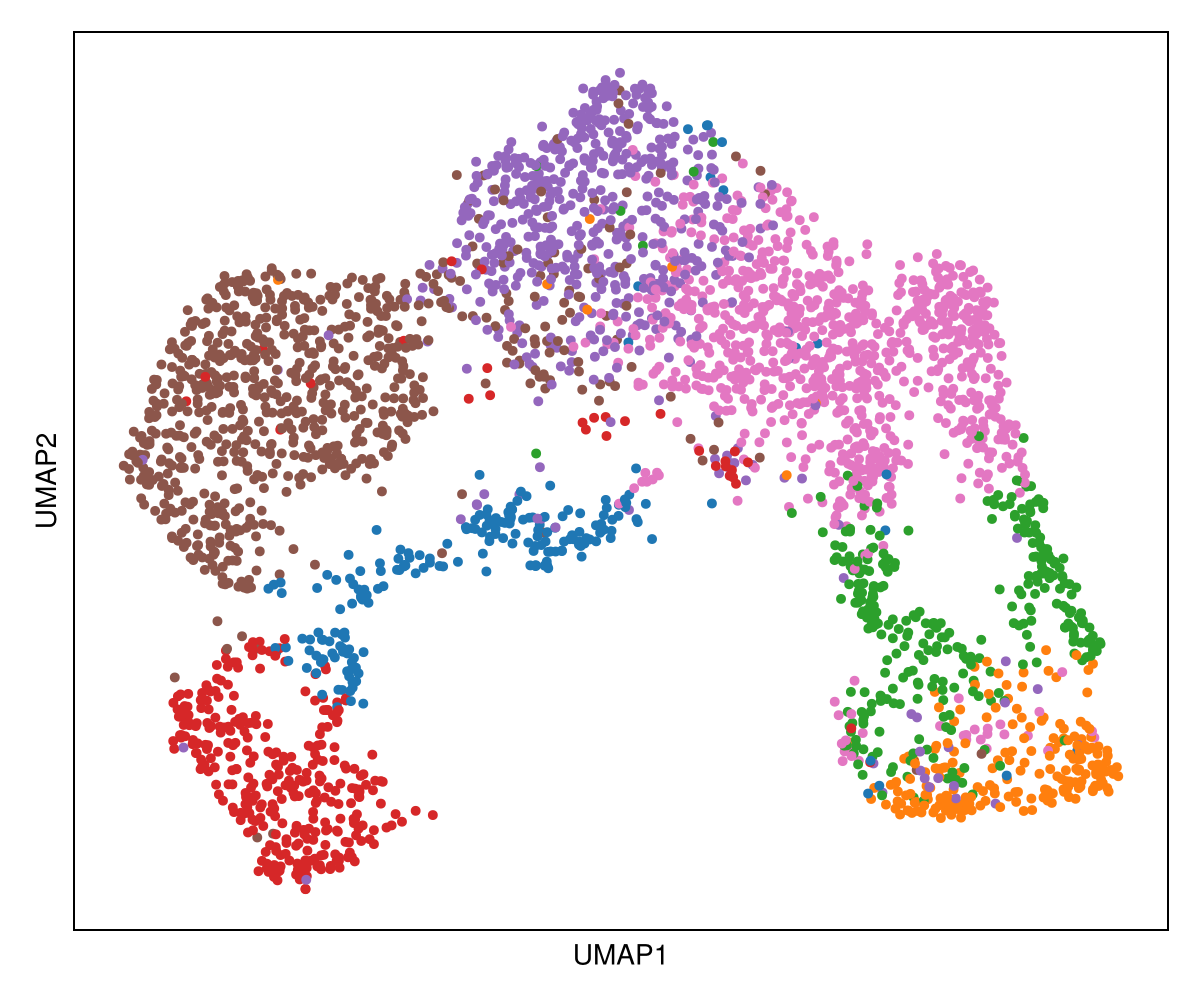

In [61]:
fig = MK.Figure(resolution=(600, 500))
    
ax1 = MK.Axis(fig[1,1]; xticklabelsize=12, yticklabelsize=12, xticksvisible=false, 
            xticklabelsvisible=false, yticksvisible=false, yticklabelsvisible=false,
            xgridvisible = false, ygridvisible = false, xlabel = names(umap_df)[2], ylabel = names(umap_df)[3]);

MK.scatter!(ax1, umap_df.UMAP1 , umap_df.UMAP2; color=cluster_colors , strokewidth=0, markersize=7)

fig

In [266]:
# save("UMAP.png", fig)

CairoMakie.Screen{IMAGE}
